# Úkol č. 1 - redukce dimenzionality a binární klasifikace

  * **Deadline je do 8. 5. 2023, 23:59:59**, pokud odevzdáte úkol do 14. 5. 2023, 23:59:59, budete penalizování -12 body, pozdější odevzdání je bez bodu.
  * V rámci tohoto úkolu se musíte vypořádat s vysokou dimenzí problému a poté úspěšně aplikovat vhodný klasfikační model.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budou strhávány body.

## Zdroj dat

 * Zdrojem dat jsou soubory `train.csv` a `evaluate.csv`.
 * Jedná se o obrázky 28x28 pixelů ve stupních šedi, které byly získány z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.
 * Soubor `evaluate.csv` obsahuje testovací data bez hodnot skutečných labelů.

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**:
  * V notebooku načtěte data ze souboru `train.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Některé obrázky také zobrazte.
  * Postupně aplikujte modely **SVM**, **naivní Bayesův klasifikátor** a **LDA**, přičemž pro každý z nich:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Vyberte si hlavní hyperparametry k ladění (pokud model má hyperparametry) a najděte jejich nejlepší hodnoty.
      * Experimentujte se standardizací/normalizací dat.
      * U SVM vyzkoušejte alespoň dvě různé jádrové funkce.
      * Získané výsledky vždy řádně okomentujte.


  * Postupně aplikujte metody redukce dimenzionality PCA a LLE, přičemž pro každou z nich: 
      * Zopakujte předchozí kroky a pokuste modely vylepšit
      * Zkoumejte jaká dimenze je z hlediska výkonnosti finálního modelu nejlepší.
      * Získané výsledky vždy řádně okomentujte.
    
  * Ze všech zkoušených možností vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici.
  
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluate.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do dvou sloupců: **ID**, **predikce labelu**. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
   
   * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,label
0,0
1,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

## Průzkum dat

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns

seed = 2342

Podívám se, jak vypadá prvních pár řádků.

In [2]:
df = pd.read_csv("train.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,1,2,1,4,2,0,0,...,37,73,65,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,105,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,135,135,184,59,0,2,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,70,0,0,0,0,0,0,0,0,0


Dataset obsahuje v každém řádku 28x28 hodnot jednotlivých pixelů a vysvětlovanou proměnnou `label`. Zkontroluji, jakých nabývá vysvětlovaná proměnná hodnot.

In [3]:
df["label"].unique()

array([1, 0])

Z popisu datasetu na Kaggelu by hodnota 0 měla odpovídat tričku a hodnota 1 kalhotům. Abych to ověřil, vytvořím si funkci, která mi zobrazí zadaný řádek datasetu jako obrázek.

In [63]:
def show_img(row, has_label=False):
    #remove label and reshape the row to 2d image matrix
    if has_label:
        label = row["label"]
        row = row.drop('label')
    img = np.array(row, dtype=int).reshape((28, 28))
    #plot in grayscale
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()
    if has_label:
        print(f"Label: {label}")

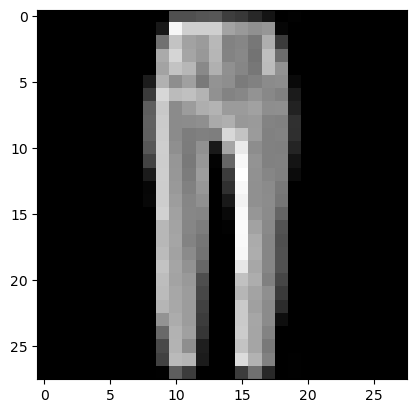

Label: 1


None

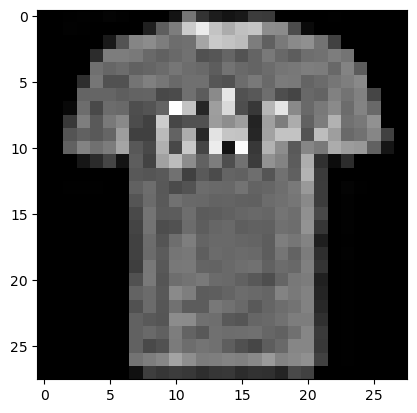

Label: 0


None

In [64]:
#display 1st and 2nd image 
display(show_img(df.iloc[0], True))
display(show_img(df.iloc[1], True))

Pro první dva řádky label skutečně odpovídá.

## Trénování na datasetu původní dimenze

Data si rozdělím na trénovací a testovací. Použiji křížovou validaci, takže samostatnou validační množinu nepotřebuji.

In [6]:
y = df["label"]
X = df.drop("label", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
print(X_train.shape)
print(y_train.shape)

(1920, 784)
(1920,)


### 1) SVM
SVM by mohl fungovat celkem dobře. S velkým množstvím parametrů by model neměl mít model problém a pomocí jádrových funkcí dokáže popsat i poměrně složité nelineární rozhodovací hranice.

Pomocí grid_search a křížové validace se pokusím najít nejlepší hyperparamery. Vyzkouším různé jádrové funkce a různou míru regularizace.

In [7]:
from sklearn.svm import SVC

#define tested hyperparameters
param_grid = {'C': [0.1, 1, 10, 50, 100],  
              'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
             }

#create and fit model
svm_grid = GridSearchCV(SVC(), param_grid, verbose = 1,n_jobs=-1) 
svm_grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 50, 100],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             verbose=1)

In [8]:
print(svm_grid.best_params_)
print(f"Validation accuracy: {svm_grid.best_score_}")

{'C': 10, 'kernel': 'rbf'}
Validation accuracy: 0.9880208333333333


Pro regularizační koeficient s hodnotou 10 a gausovské jádro vychází validační přesnost téměř 99%. To na první pokus vypadá velmi dobře.

Pro lepší znázornění, jak se model chová s odlišnými hyparametry, si vytvořím funkci, která mi vykreslí průměrnou validační přesnost pro různé kombinace hyperparametrů.

In [9]:
def plot_grid_search(results, x, y, hue, logx=False):
    res_df = pd.DataFrame(results)
    if not hue:
        sns.lineplot(data=results, x=x, y=y)
    else:
        sns.lineplot(data=results, x=x, y=y, hue=hue)
        
    if logx:
        plt.xscale('log')
    #display(res_df.head())

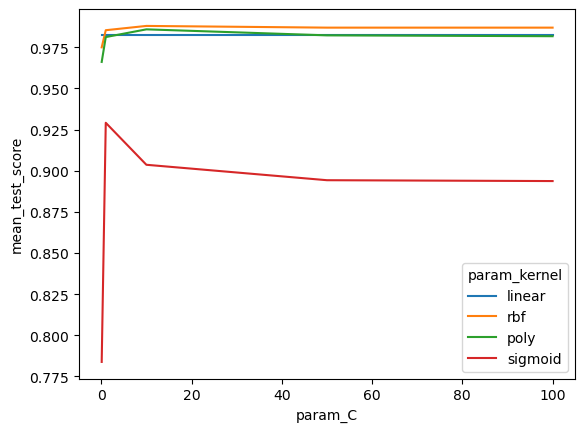

In [10]:
plot_grid_search(svm_grid.cv_results_, x="param_C", y="mean_test_score", hue="param_kernel")

Je vidět, že lineární a polynomiální (defaultně polynom 3. stupně) jádra si vedou velmi podobně s přesností cca 98% a gausovské je ještě o trochu lepší. Oproti tomu jádrová funkce `sigmoid` dosahuje výrazně nižších výsledků okolo 92%.

Také můžeme pozorovat, že pro velkou regularizaci (`C = 0.1`) jsou výsledky výrazně horší.

Ještě zkusím, jestli model nezlepší standartizace nebo normalizace dat. Nejrpve zkusím transformovat jednotlivé sloupce pomocí `StandartScaler` a `MinMaxScaler`. MinMax normalizace pravděpodobně nebude mít velký vliv, jelikož data už jistým způsobem normalizovaná jsou - nejnižší hodnota je 0 a nejvyšší 255. Všechny sloupce mají tedy stejné měřítko už od základu.

K hledání nejlepší kombinace hyperparametrů a případného předzpracování budu používat `Pipeline`.

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    [
        # preprocessing will be filled with parameter grid
        ("preprocessing", "passthrough"),
        ("svc", SVC()),
    ], 
)

In [12]:
pipe_grid = {
    'preprocessing' : [MinMaxScaler(), StandardScaler()],
    'svc__C': [0.1, 1, 10, 50, 100],  
    'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
}

In [13]:
svm_grid_prep = GridSearchCV(pipe, pipe_grid, verbose = 1,n_jobs=-1) 
svm_grid_prep.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessing', 'passthrough'),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'preprocessing': [MinMaxScaler(), StandardScaler()],
                         'svc__C': [0.1, 1, 10, 50, 100],
                         'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             verbose=1)

In [14]:
print(f"Pipe: {svm_grid_prep.best_params_}")
print(f"Pipe validation accuracy: {svm_grid_prep.best_score_}")

Pipe: {'preprocessing': StandardScaler(), 'svc__C': 100, 'svc__kernel': 'poly'}
Pipe validation accuracy: 0.9869791666666666


Normalizace ani standartizace sloupců přesnost nezvýšila.

Zkusím ještě znormalizovat jednotlivé řádky.

In [15]:
from sklearn.preprocessing import Normalizer

pipe_rnorm = Pipeline([('scaler', Normalizer()), ('svc', SVC())])

In [16]:
pipe_grid = {
    'svc__C': [0.1, 1, 10, 50, 100],  
    'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
}
svm_grid_rnorm = GridSearchCV(pipe_rnorm, pipe_grid, verbose = 1,n_jobs=-1) 
svm_grid_rnorm.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', Normalizer()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1, 10, 50, 100],
                         'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             verbose=1)

In [17]:
print(f"Normalized rows: {svm_grid_rnorm.best_params_}")
print(f"Normalized rows validation accuracy: {svm_grid_rnorm.best_score_}")

Normalized rows: {'svc__C': 10, 'svc__kernel': 'rbf'}
Normalized rows validation accuracy: 0.9916666666666666


Normalizace jednotlivých obrázků už ale přinesla zlepšení. Validační přesnost je přes 99%. Hyperparametry modelu zůstaly stejné, jako u při trénování na původních datech.

### 2) Naivní bayesův klasifikátor

Díky tomu, že v naivním bayesovi probíhá odhad jednotlivých podmíněných pravděpodobností nezávisle na ostatních, je tento model velmi odolný vůči vysoké dimenzi, takže by se zadaným datasetem o 784 příznacích neměl mít žádný problém. Zároveň ale předpokládá nezávislost jednotlivých pixelů (pro fixní třídu/label), která zde téměř uričtě neplatí, a to by mohlo mít negativní vliv na výslednou přesnost (NB ale dává často dobré výsledky, i pokud nezávislost splněna není).

Nejprve se ale musím rozhodnout, jak odhadovat podmíněné pravděpodobnosti (který model naivního bayese z knihovny vybrat).

Jednotlivé pixely pravděpodobně nebudou mít normální rozdělení. Podívám se na pár jejich histogramů.

<AxesSubplot: xlabel='pixel345', ylabel='Count'>

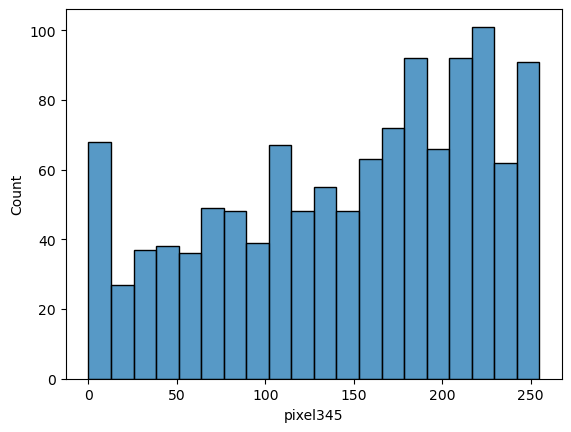

In [18]:
y = 0  #0 or 1
pixel_num = 345 # 1-784

cat_df = df[df['label'] == y]
sns.histplot(cat_df[f'pixel{pixel_num}'],bins=20)

Pixely na krajích obrázků mají často pouze jednu hodnotu (například 0) a rozdělení určitě není normální. Pixely více uprostřed se normálnímu rozdělení podobají trochu více, ale pořád k němu mají dost daleko. I přesto neprve vyzkouším model naivního bayese s normálním rozdělením, protože může mít dobré výsledky, i když data z normálního rozdělení nepochází.

Zároveň díky tomu, že k hodnotám pixelů budu přistupovat jako ke spojité veličině, můžu nad daty provádět různé transformace (standartizaci, normalizaci), což bych u kategorických dat dělat nemohl.

In [19]:
from sklearn.naive_bayes import GaussianNB

#define tested hyperparameters
param_grid = {'var_smoothing': np.logspace(0,-12, num=100)
}

#create and fit model
nb_grid = GridSearchCV(GaussianNB(), param_grid, verbose = 1,n_jobs=-1) 
nb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 7.56463328e-01, 5.72236766e-01, 4.32876128e-01,
       3.27454916e-01, 2.47707636e-01, 1.87381742e-01, 1.41747416e-01,
       1.07226722e-01, 8.11130831e-02, 6.13590727e-02, 4.64158883e-02,
       3.51119173e-02, 2.65608778e-02, 2.00923300e-02, 1.51991108e-02,
       1.14975700e-02, 8.69749003e-03...
       6.13590727e-10, 4.64158883e-10, 3.51119173e-10, 2.65608778e-10,
       2.00923300e-10, 1.51991108e-10, 1.14975700e-10, 8.69749003e-11,
       6.57933225e-11, 4.97702356e-11, 3.76493581e-11, 2.84803587e-11,
       2.15443469e-11, 1.62975083e-11, 1.23284674e-11, 9.32603347e-12,
       7.05480231e-12, 5.33669923e-12, 4.03701726e-12, 3.05385551e-12,
       2.31012970e-12, 1.74752840e-12, 1.32194115e-12, 1.00000000e-12])},
             verbose=1)

In [20]:
print(nb_grid.best_params_)
print(f"Validation accuracy: {nb_grid.best_score_}")

{'var_smoothing': 0.002154434690031882}
Validation accuracy: 0.9296875


Maximální dosažená validační přesnost je necelých 93% při hodnotě vyhlazovacího parametru 0.00215. Podívám se, jak velký má vyhlazovací parametr vliv.

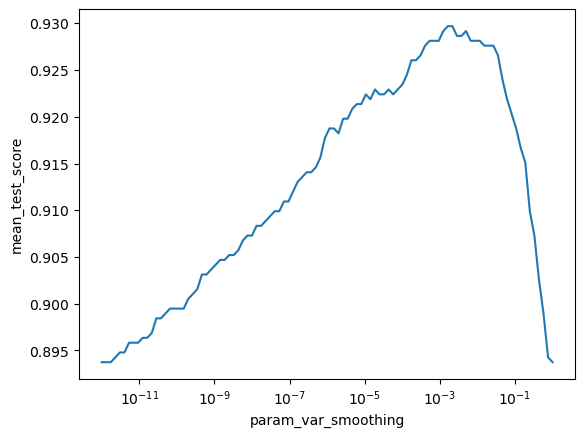

In [21]:
plot_grid_search(nb_grid.cv_results_, x="param_var_smoothing", y="mean_test_score", hue=False, logx=True)

Celkovou přesnost správná volba zvýšila o 3% oproti defaultnímu nastavení (1e-9).

Stejně jako u SVM vyzkouším, jaký vliv má na model standartizace a normalizace dat.

In [22]:
pipe = Pipeline(
    [
        # preprocessing will be filled with parameter grid
        ("preprocessing", "passthrough"),
        ('nb', GaussianNB()),
    ], 
)

pipe_grid = {
    'preprocessing' : [MinMaxScaler(), StandardScaler(), Normalizer()],
    'nb__var_smoothing': np.logspace(0,-12, num=100)
}

In [23]:
nb_grid_prep = GridSearchCV(pipe, pipe_grid, verbose = 1,n_jobs=-1)
nb_grid_prep.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessing', 'passthrough'),
                                       ('nb', GaussianNB())]),
             n_jobs=-1,
             param_grid={'nb__var_smoothing': array([1.00000000e+00, 7.56463328e-01, 5.72236766e-01, 4.32876128e-01,
       3.27454916e-01, 2.47707636e-01, 1.87381742e-01, 1.41747416e-01,
       1.07226722e-01, 8.11130831e-02, 6.13590727e-02, 4.64158883e-02,
       3.51119173e-02, 2.65608778e-0...
       2.00923300e-10, 1.51991108e-10, 1.14975700e-10, 8.69749003e-11,
       6.57933225e-11, 4.97702356e-11, 3.76493581e-11, 2.84803587e-11,
       2.15443469e-11, 1.62975083e-11, 1.23284674e-11, 9.32603347e-12,
       7.05480231e-12, 5.33669923e-12, 4.03701726e-12, 3.05385551e-12,
       2.31012970e-12, 1.74752840e-12, 1.32194115e-12, 1.00000000e-12]),
                         'preprocessing': [MinMaxScaler(), StandardScaler(),
                                           Normalizer()]},
             verbose=1)

In [24]:
print(f"Pipe: {nb_grid_prep.best_params_}")
print(f"Pipe validation accuracy: {nb_grid_prep.best_score_}")

Pipe: {'nb__var_smoothing': 0.5722367659350217, 'preprocessing': Normalizer()}
Pipe validation accuracy: 0.9609375


Normalizace jednotlivých řádků výslednou přesnost opět zvýšila a to o více než 3% na 96%.

Ještě vyzkouším, jestli by nebylo lepší data brát jako kategorická (jednotlivé příznaky mohou nabývat pouze 256 hodnot) a při odhadu podmíněných pravděpodobností použít kategorické rozdělení.

In [25]:
from sklearn.naive_bayes import CategoricalNB

param_grid = {'alpha': np.arange(0.05, 1.5, 0.05)
}

#create and fit model
nbcat_grid = GridSearchCV(CategoricalNB(min_categories=256), param_grid, verbose = 1,n_jobs=-1) 
nbcat_grid.fit(X_train, y_train)

Fitting 5 folds for each of 29 candidates, totalling 145 fits


GridSearchCV(estimator=CategoricalNB(min_categories=256), n_jobs=-1,
             param_grid={'alpha': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 ,
       1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45])},
             verbose=1)

In [26]:
print(nbcat_grid.best_params_)
print(f"Validation accuracy: {nbcat_grid.best_score_}")

{'alpha': 0.2}
Validation accuracy: 0.9609375


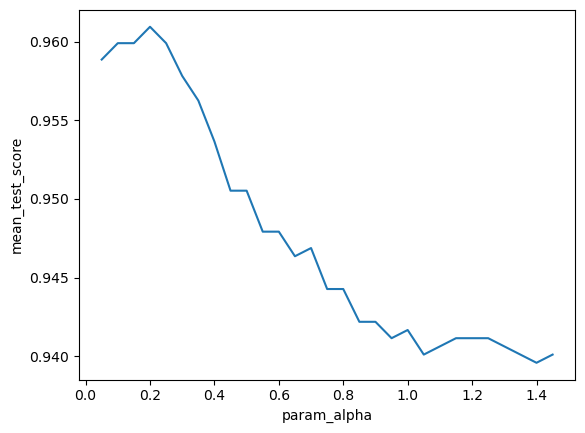

In [27]:
plot_grid_search(nbcat_grid.cv_results_, x="param_alpha", y="mean_test_score", hue=False)

S volbou vyhlazovacího parametru `alpha = 0.2` vychází validační přesnost úplně stejně jako u gausovského naivního bayese s normalizací řádků.

### 3) LDA
Lineární diskrimanční analýza předpokládá, že jsou varianční matice stejné pro všechny třídy a že mají data vícerozměrné normální rozdělení, což v tomto případě pravděpodobně platit nebude. Nicméně stejně jako u naivního bayese může dávát dobré výsledky, i pokud tyto podmínky splněny nejsou.

Z předpokladu o shodnosti variančních matic zároveň plyne, že rozhodovací hranice modelu je určena nadrovinou a model se tak pokouší pouze o lineární separaci dat (jak vlastně plyne i z názvu). Pokud by rozhodovací hranice nebyla lineární, model to nedokáže zohlednit a bude dávat horší výsledky.

Pokusím se najít nejlepší hyperparametry.

In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#define tested hyperparameters
param_grid = {'solver': ['svd', 'lsqr', 'eigen'],
              'shrinkage' : ['auto', None]
}

#create and fit model
LDA_grid = GridSearchCV(LinearDiscriminantAnalysis(), param_grid, verbose = 1,n_jobs=-1) 
LDA_grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/ivan/miniconda3/envs/ml1/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/ml1/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ivan/miniconda3/envs/ml1/lib/python3.9/site-packages/sklearn/discriminant_analysis.py", line 589, in fit
    raise NotImplementedError("shrinkage not supported")
NotImplementedError: shrinkage not supported

---------------------------------------------------------

GridSearchCV(estimator=LinearDiscriminantAnalysis(), n_jobs=-1,
             param_grid={'shrinkage': ['auto', None],
                         'solver': ['svd', 'lsqr', 'eigen']},
             verbose=1)

Některé kombinace zvolených hyperparametrů spolu nefungují, takže hlasí chybu, ale nijak to neovlivňuje ostatní kombinace, které fungují správně. Podívám se na výslednou přesnost a nejlepší hyperparametry modelu.

In [29]:
print(LDA_grid.best_params_)
print(f"Validation accuracy: {LDA_grid.best_score_}")

{'shrinkage': 'auto', 'solver': 'lsqr'}
Validation accuracy: 0.9796875


Výsledná dosažená přesnost je téměř 98%. Podívám se ještě, jakou přesnost měly ostatní (validní) kombinace.

In [30]:
#transfrom results to dataframe and drop invalid combinations
res = pd.DataFrame(LDA_grid.cv_results_).dropna(subset="mean_test_score")

res[["param_shrinkage", "param_solver", "mean_test_score"]]

,param_shrinkage,param_solver,mean_test_score
1,auto,lsqr,0.979688
2,auto,eigen,0.979688
3,None,svd,0.933854
4,None,lsqr,0.931250


Je vidět, že zapnutí hyperparameter *shrinkage* (který funguje jako jistá forma regularizace pro zlepšení odhadu variančních matic) výrazně zlepší validační přesnost. Z 93% na 98%.

Dále otestuji, jestli standartizace nebo normalizace nezlepší validační přesnost ještě víc.

In [31]:
pipe = Pipeline(
    [
        # preprocessing will be filled with parameter grid
        ("preprocessing", "passthrough"),
        ('lda', LinearDiscriminantAnalysis()),
    ], 
)

pipe_grid = {
    'preprocessing' : [MinMaxScaler(), StandardScaler(), Normalizer()],
    'lda__solver': ['svd', 'lsqr', 'eigen'],
    'lda__shrinkage' : ['auto', None]
}

In [32]:
lda_grid_prep = GridSearchCV(pipe, pipe_grid, verbose = 1,n_jobs=-1)
lda_grid_prep.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/home/ivan/miniconda3/envs/ml1/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ivan/miniconda3/envs/ml1/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ivan/miniconda3/envs/ml1/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/ivan/miniconda3/envs/ml1/lib/python3.9/site-packages/sklearn/discriminant_analysis.py", line 589,

GridSearchCV(estimator=Pipeline(steps=[('preprocessing', 'passthrough'),
                                       ('lda', LinearDiscriminantAnalysis())]),
             n_jobs=-1,
             param_grid={'lda__shrinkage': ['auto', None],
                         'lda__solver': ['svd', 'lsqr', 'eigen'],
                         'preprocessing': [MinMaxScaler(), StandardScaler(),
                                           Normalizer()]},
             verbose=1)

In [33]:
print(f"Pipe: {lda_grid_prep.best_params_}")
print(f"Pipe validation accuracy: {lda_grid_prep.best_score_}")

Pipe: {'lda__shrinkage': 'auto', 'lda__solver': 'lsqr', 'preprocessing': Normalizer()}
Pipe validation accuracy: 0.9802083333333333


Normalizace jednotlivých řádků opět přesnost zvýšila, i když téměř zanedbatelně.

## Redukce dimenze pomocí PCA a LLE

PCA dělá projekci na podprostor menší dimenze a zároveň se snaží minimalizovat výslednou chybu projekce (což je ekvivaletní maximalizaci rozptylu projektovaných bodů). LLE dělá také projekci na podprostor menší dimenze, ale snaží se přitom zachovat hlavně lokální vztahy jednotlivých bodů. LLE v důsledku dokáže narozdíl od PCA podchytit i složitější nelineární závislosti mezi jednotlivými příznaky.

Na trénovací data použiji neprve PCA a podívám se, kolik celkového rozptylu jednotlivé komponenty vysvětlují.

,0
0,0.372010
1,0.160301
2,0.047095
3,0.037648
4,0.034348
5,0.026705
6,0.021465
7,0.014365
8,0.012882
9,0.011824


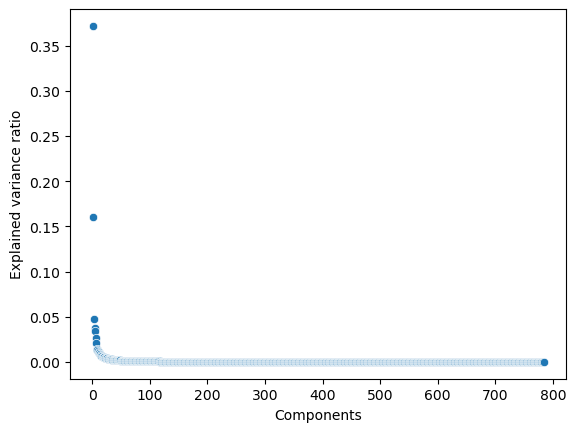

In [34]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)

sns.scatterplot(x=np.arange(1, pca.n_components_ + 1), y=pca.explained_variance_ratio_)
plt.ylabel('Explained variance ratio')
plt.xlabel('Components')
pca_df = pd.DataFrame(pca.explained_variance_ratio_)
pca_df.head(10)

Můžeme vidět, že více než polovina celkového rozptylu je vysvětlena pouze prvními dvěma komponentami. Pro další komponenty je podíl celkového rozptylu o dost menší. 

Ještě se podívám na procento celkového rozptylu vysvětleného pomocí prvních *n* hlavních komponent dohromady.

In [35]:
for i in range (10, 101, 10):
    print(f"Explained variance in first {i} principal components: {round(pca_df.head(i).sum()[0], 3)}")

Explained variance in first 10 principal components: 0.739
Explained variance in first 20 principal components: 0.815
Explained variance in first 30 principal components: 0.856
Explained variance in first 40 principal components: 0.881
Explained variance in first 50 principal components: 0.899
Explained variance in first 60 principal components: 0.912
Explained variance in first 70 principal components: 0.923
Explained variance in first 80 principal components: 0.931
Explained variance in first 90 principal components: 0.939
Explained variance in first 100 principal components: 0.945


Růst vysvětleného rozptylu v prvních *n* komponentách se s počtem komponent značně zpomaluje. 50% dosáhne již v prvních dvou komponentách, ale 90% až po 50. komponentě.

Teď už přejdu k jednotlivým klasifikačním modelům a pro každý z nich vyzkouším PCA i LLE a pokusím se najít ideální dimenzi, ve které mají modely nejvyšší přesnost.

### 1) SVM

Spolu s počtem hlavních komponent zkusím opět najít i ostatní hyperparametry modelu, abych měl jistotu, že mám ty nejlepší a snížení dimenze je neovlivnilo.

Nejprve zkusím dimenzi redukovat pomocí PCA.

In [36]:
from sklearn.manifold import LocallyLinearEmbedding

Pro SVM opět vyzkouším dvě různá jádra a několik hodnot vyhlazovacího parametru. Zároveň znovu otestuji, jestli nepomůže před redukcí dimenzi data normalizovat nebo standartizovat.

In [37]:
pipe = Pipeline(
    [
        # preprocessing will be filled with parameter grid
        ("preprocessing", "passthrough"),
        ("reduce_dim", PCA()),
        ("svc", SVC()),
    ], 
)

pipe_grid = [
    {
        "preprocessing" : ["passthrough", MinMaxScaler(), StandardScaler(), Normalizer()],
        "reduce_dim__n_components": [2, 10, 20, 25, 30, 35, 40, 50, 70, 110, 170, 250, 400],
        "svc__C": [5, 15, 30],
        'svc__kernel': ['rbf', 'poly']
    }
]

In [38]:
svm_pca_grid = GridSearchCV(pipe, pipe_grid, verbose = 1,n_jobs=-1) 
svm_pca_grid.fit(X_train, y_train)

Fitting 5 folds for each of 312 candidates, totalling 1560 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessing', 'passthrough'),
                                       ('reduce_dim', PCA()), ('svc', SVC())]),
             n_jobs=-1,
             param_grid=[{'preprocessing': ['passthrough', MinMaxScaler(),
                                            StandardScaler(), Normalizer()],
                          'reduce_dim__n_components': [2, 10, 20, 25, 30, 35,
                                                       40, 50, 70, 110, 170,
                                                       250, 400],
                          'svc__C': [5, 15, 30],
                          'svc__kernel': ['rbf', 'poly']}],
             verbose=1)

Podívám se na výslednou nejlepší validační přesnost a odpovídající hyperparametry.

In [39]:
print(f"Pipe best parameters: {svm_pca_grid.best_params_}")
print(f"Pipe validation accuracy: {svm_pca_grid.best_score_}")

Pipe best parameters: {'preprocessing': 'passthrough', 'reduce_dim__n_components': 30, 'svc__C': 15, 'svc__kernel': 'rbf'}
Pipe validation accuracy: 0.99375


Výsledná přesnost se opět o něco zlepšila na 99.375% za použití pouze prvních 30 hlavních komponent. Ostatní hyperparametry u SVM zůstaly stejné, jako při trénování před redukcí dimenzionality. Žádná forma normalizace ani standartizace dat zde už přesnost nezlepšila.

Vykreslím si graf, jak se pohybovala validační přesnost v závislost na počtu hlavních komponent a použití normalizace/standartizace.

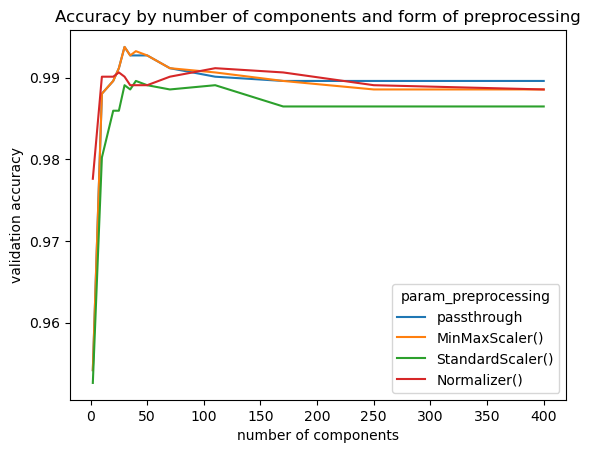

In [40]:
def plot_pca(grid_results, constraints=None):
    res_df = pd.DataFrame(grid_results)
    #convert to string
    res_df['param_preprocessing'] = res_df['param_preprocessing'].astype("string")

    #inspect only for specific constraints
    if constraints:
        for key, x in constraints.items():
            res_df = res_df.loc[(res_df[key] == x)]

    sns.lineplot(data=res_df, x="param_reduce_dim__n_components", y="mean_test_score", hue="param_preprocessing", estimator=None
                ).set(
                    title='Accuracy by number of components and form of preprocessing',
                    xlabel='number of components', ylabel='validation accuracy'
                )
    
    
#dict of fixed constraints
d = {'param_svc__C' : 15, 'param_svc__kernel' : 'rbf'}

plot_pca(svm_pca_grid.cv_results_, d)

Je vidět, že přesnost s rostoucím počtem komponent nejprve prudce roste, ale u cca 30 hlavních komponent se růst zastaví a přidání dalších komponent přesnost pomalu snižuje.

Žádné předchozí tranformace dat také přesnost nezvýšily, i když `MinMax` normalizace dává stejné výsledky, jako netransformovaná data.

Teď vyzkouším to samé pro LLE, akorát zkusím najít ještě ideální počet sousedů. Abych to urychlil, nebudu hledat nejlepší hyperparametry u SVM, ale použiji hodnoty `C=15` a `kernel='rbf`, jelikož zatím pokaždé vyšly nejlépe.

In [41]:
pipe = Pipeline(
    [
        ("preprocessing", "passthrough"),
        ("reduce_dim", LocallyLinearEmbedding()),
        ("svc", SVC(C=15, kernel='rbf')),
    ]
)

pipe_grid = [
    {
        "preprocessing" : ["passthrough", MinMaxScaler(), StandardScaler(), Normalizer()],
        "reduce_dim__n_components": [2, 10, 20, 25, 30, 35, 40, 50, 70, 110, 170, 250, 400],
        "reduce_dim__n_neighbors": [3, 5, 7, 12],
    }
]

In [42]:
svm_lle_grid = GridSearchCV(pipe, pipe_grid, verbose = 1,n_jobs=-1) 
svm_lle_grid.fit(X_train, y_train)

Fitting 5 folds for each of 208 candidates, totalling 1040 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessing', 'passthrough'),
                                       ('reduce_dim', LocallyLinearEmbedding()),
                                       ('svc', SVC(C=15))]),
             n_jobs=-1,
             param_grid=[{'preprocessing': ['passthrough', MinMaxScaler(),
                                            StandardScaler(), Normalizer()],
                          'reduce_dim__n_components': [2, 10, 20, 25, 30, 35,
                                                       40, 50, 70, 110, 170,
                                                       250, 400],
                          'reduce_dim__n_neighbors': [3, 5, 7, 12]}],
             verbose=1)

Zobrazím si nejlepší kombinaci parametrů a odpovídající přesnost.

In [43]:
print(f"Pipe best parameters: {svm_lle_grid.best_params_}")
print(f"Pipe validation accuracy: {svm_lle_grid.best_score_}")

Pipe best parameters: {'preprocessing': Normalizer(), 'reduce_dim__n_components': 35, 'reduce_dim__n_neighbors': 5}
Pipe validation accuracy: 0.9942708333333332


Maximální validační přesnost se opět zvýšila. Stejně jako u PCA se podívám na vliv počtu komponent na přesnosti. Zároveň si zobrazím i vliv počtu sousedů.

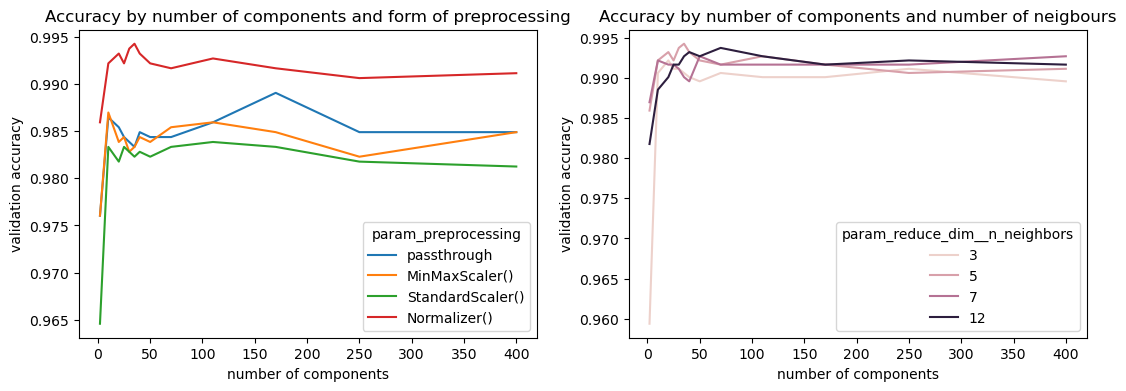

In [120]:
def plot_lle(grid_results, constraints=None, best_neigh=5, best_prep="Normalizer()"):
    res_df = pd.DataFrame(grid_results)
    #convert to string
    res_df['param_preprocessing'] = res_df['param_preprocessing'].astype("string")
    
    #inspect only for specific constraints
    if constraints:
        for key, x in constraints.items():
            res_df = res_df.loc[(res_df[key] == x)]

    #inspect only for best number of neighbours - 5
    sub_df1 = res_df.loc[(res_df['param_reduce_dim__n_neighbors'] == best_neigh)]
    #inspect only for best preprocessing (normalizer)
    sub_df2 = res_df.loc[(res_df['param_preprocessing'] == best_prep)]

    fig, axes = plt.subplots(1, 2, figsize=(13, 4))

    sns.lineplot(ax=axes[0], data=sub_df1, x="param_reduce_dim__n_components", y="mean_test_score", hue="param_preprocessing", 
                 estimator=None).set(
                    title='Accuracy by number of components and form of preprocessing',
                    xlabel='number of components', ylabel='validation accuracy'
                )
    sns.lineplot(ax=axes[1], data=sub_df2, x="param_reduce_dim__n_components", y="mean_test_score", hue="param_reduce_dim__n_neighbors",
                 estimator=None).set(
                    title='Accuracy by number of components and number of neigbours',
                    xlabel='number of components', ylabel='validation accuracy'
                )
    
plot_lle(svm_lle_grid.cv_results_)

Na levém grafu je vidět, že normalizace jednotlivých řádků opět pomohla a narozdíl od transformací sloupců přesnost téměř o procento zvýšila. Na pravém grafu jsou přesnosti pro různé počty sousedů v LLE. Zajímavé je, že pro zvyšující se počet sousedů se zvyšuje i počet komponent pro maximální přesnost - pro 3 sousedy je maximum okolo 20 komponent, ale pro 12 sousedů nastává maximální validační přesnot při 70 komponentách.

Pro oba grafy platí, že nejvyšší přesnosti nastávají při nižším počtu komponent a potom přesnost pomalu klesá. Jedinou výjimkou je případ na levém grafu, kde pro originální data je výrazné maximum při 170 komponentách.

### 2) Naivní bayes

U SVM snížení dimenze k vyšší přesnosti pomohlo. Otestuji, jestli to tak dopadne i u naivního bayese.

Postupovat budu stejně jako výše u SVM.

In [45]:
pipe = Pipeline(
    [
        # preprocessing will be filled with parameter grid
        ("preprocessing", "passthrough"),
        ("reduce_dim", PCA()),
        ("nb", GaussianNB()),
    ], 
)

pipe_grid = [
    {
        "preprocessing" : ["passthrough", MinMaxScaler(), StandardScaler(), Normalizer()],
        "reduce_dim__n_components": [2, 10, 20, 30, 50, 70, 110, 170, 250, 400],
        "nb__var_smoothing" : np.logspace(0,-9, num=10)
    }
]

In [46]:
nb_pca_grid = GridSearchCV(pipe, pipe_grid, verbose = 1,n_jobs=-1) 
nb_pca_grid.fit(X_train, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessing', 'passthrough'),
                                       ('reduce_dim', PCA()),
                                       ('nb', GaussianNB())]),
             n_jobs=-1,
             param_grid=[{'nb__var_smoothing': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09]),
                          'preprocessing': ['passthrough', MinMaxScaler(),
                                            StandardScaler(), Normalizer()],
                          'reduce_dim__n_components': [2, 10, 20, 30, 50, 70,
                                                       110, 170, 250, 400]}],
             verbose=1)

In [47]:
print(f"Pipe best parameters: {nb_pca_grid.best_params_}")
print(f"Pipe validation accuracy: {nb_pca_grid.best_score_}")

Pipe best parameters: {'nb__var_smoothing': 0.01, 'preprocessing': 'passthrough', 'reduce_dim__n_components': 20}
Pipe validation accuracy: 0.9786458333333334


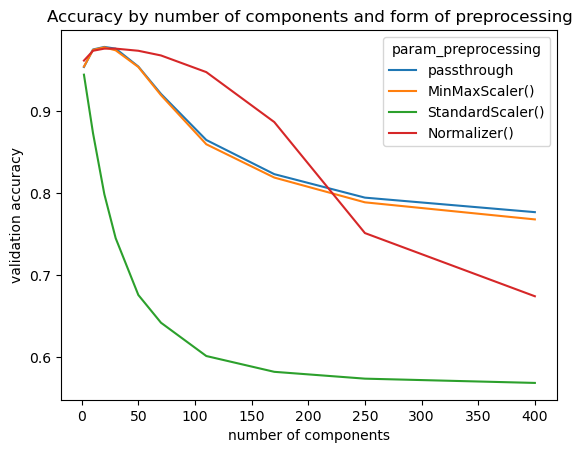

In [48]:
d = {"param_nb__var_smoothing" : 0.01}
plot_pca(nb_pca_grid.cv_results_, d)

Při pouhých 20 komponentách dosahuje model přesnosti necelých 98%, což je o 2% více, než při trénování na datech plné dimenze.

Z grafu výše můžeme pozorovat, že dobrou přesnost dostáváme pouze pro menší počet komponent a potom přesnost prudce klesá, zejména pro standartizovaná data. To se děje pravděpodobně kvůli specifické volbě vyhlazovací parametru.

Jediná transformace, která vypadá nadějně, je opět jenom normalizace jednotlivých řádků, ale při 20 hlavních komponentách jí netransformovaná data předženou.

Dále se pokusím výsledek zlepši redukcí dimenze pomocí LLE.

In [49]:
pipe = Pipeline(
    [
        ("preprocessing", "passthrough"),
        ("reduce_dim", LocallyLinearEmbedding()),
        ("nb", GaussianNB())
    ]
)

pipe_grid = [
    {
        "preprocessing" : ["passthrough", MinMaxScaler(), StandardScaler(), Normalizer()],
        "nb__var_smoothing" : np.logspace(0,-9, num=5),
        "reduce_dim__n_components": [2, 10, 20, 25, 30, 35, 40, 50, 70, 110, 170, 250, 400],
        "reduce_dim__n_neighbors": [3, 5, 7, 12],
    }
]

In [50]:
nb_lle_grid = GridSearchCV(pipe, pipe_grid, verbose = 1,n_jobs=-1) 
nb_lle_grid.fit(X_train, y_train)

Fitting 5 folds for each of 1040 candidates, totalling 5200 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessing', 'passthrough'),
                                       ('reduce_dim', LocallyLinearEmbedding()),
                                       ('nb', GaussianNB())]),
             n_jobs=-1,
             param_grid=[{'nb__var_smoothing': array([1.00000000e+00, 5.62341325e-03, 3.16227766e-05, 1.77827941e-07,
       1.00000000e-09]),
                          'preprocessing': ['passthrough', MinMaxScaler(),
                                            StandardScaler(), Normalizer()],
                          'reduce_dim__n_components': [2, 10, 20, 25, 30, 35,
                                                       40, 50, 70, 110, 170,
                                                       250, 400],
                          'reduce_dim__n_neighbors': [3, 5, 7, 12]}],
             verbose=1)

In [51]:
print(f"Pipe best parameters: {nb_lle_grid.best_params_}")
print(f"Pipe validation accuracy: {nb_lle_grid.best_score_}")

Pipe best parameters: {'nb__var_smoothing': 0.005623413251903491, 'preprocessing': Normalizer(), 'reduce_dim__n_components': 50, 'reduce_dim__n_neighbors': 7}
Pipe validation accuracy: 0.990625


Pomocí LLE se podařilo překročit 99% procentní přesnost. Opět si pro lepší porozumnění vykreslím dva grafy popisující závislost přesnosti na počtu komponent.

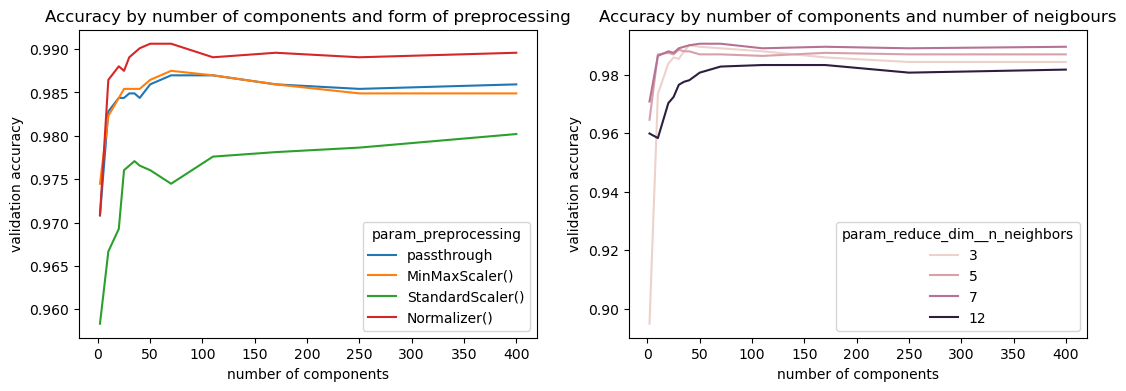

In [121]:
d = {"param_nb__var_smoothing" : 0.005623413251903491}
plot_lle(nb_lle_grid.cv_results_, d, best_neigh=7)

Grafy vypadají podobně jako u SVM. Nejlepší forma předzpracování dat je opět normalizace jednotlivých řádků a nejlepší počet sousedů je 7. S rostoucím počtem komponent přesnost pozvolně klesá a nejvšší vychází pro 50.

### 3) LDA
Stejné kroky aplikuji i pro LDA.

Nebudu testovat veškeré kombinace hyperparametrů co výše, jelikož některé spolu nefungují a vyhazují chybu. Místo toho zkusím pouze 2 kombinace, které bez redukce dimenzionality měly rozdílnou přesnost.

In [93]:
pipe = Pipeline(
    [
        # preprocessing will be filled with parameter grid
        ("preprocessing", "passthrough"),
        ("reduce_dim", PCA()),
        ("lda", LinearDiscriminantAnalysis()), #placeholder lda, will be replaced in parameter grid
    ], 
)

pipe_grid = [
    {
        "preprocessing" : ["passthrough", MinMaxScaler(), StandardScaler(), Normalizer()],
        "reduce_dim__n_components": [2, 10, 20, 30, 50, 70, 110, 170, 250, 400],
        "lda" : [LinearDiscriminantAnalysis(), LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')]
    }
]

In [83]:
lda_pca_grid = GridSearchCV(pipe, pipe_grid, verbose = 1,n_jobs=-1) 
lda_pca_grid.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessing', 'passthrough'),
                                       ('reduce_dim', PCA()),
                                       ('lda', LinearDiscriminantAnalysis())]),
             n_jobs=-1,
             param_grid=[{'lda': [LinearDiscriminantAnalysis(),
                                  LinearDiscriminantAnalysis(shrinkage='auto',
                                                             solver='lsqr')],
                          'preprocessing': ['passthrough', MinMaxScaler(),
                                            StandardScaler(), Normalizer()],
                          'reduce_dim__n_components': [2, 10, 20, 30, 50, 70,
                                                       110, 170, 250, 400]}],
             verbose=1)

In [84]:
print(f"Pipe best parameters: {lda_pca_grid.best_params_}")
print(f"Pipe validation accuracy: {lda_pca_grid.best_score_}")

Pipe best parameters: {'lda': LinearDiscriminantAnalysis(), 'preprocessing': 'passthrough', 'reduce_dim__n_components': 70}
Pipe validation accuracy: 0.984375


Maximální validační přesnost vychází 98,4%. To je lepší než na datech plné dimenze. Narozdíl od LDA výše na datech plné dimenze zde ale dosahuje vyšší přesnosti defaultní model s parametry `solver = 'svd'` a `shrinkage = None`. Normalizace ani standartizace zde také nepohomla. Podívám se ještě na graf zobrazující závlislost přesnosti na počtu komponent.

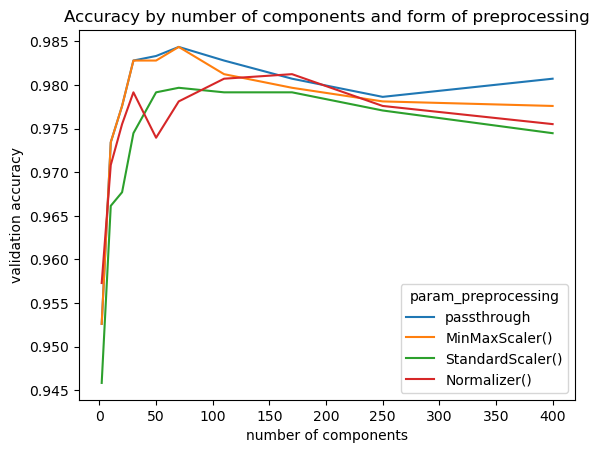

In [110]:
#inspect only better lda (with svd and without shrinkage)
res_modified = pd.DataFrame(lda_pca_grid.cv_results_)
res_modified["param_lda"] = res_modified["param_lda"].astype("string")
res_modified = res_modified[res_modified["param_lda"] == "LinearDiscriminantAnalysis()"]

plot_pca(res_modified)

Maximální přesnost u LDA nastává při 70 komponentách, což je o něco více než u ostatních modelů. Také můžeme vidět, že žádná forma normalizace ani standartizace nepomáhá. Jedině Min Max normalizace má opět podobné výsledky jako netranformovaná data, ale to bude tím, že jednotlivé sloupce mají stejné měřítko už v základu, jak jsem zmiňoval na začátku.

In [87]:
pipe = Pipeline(
    [
        # preprocessing will be filled with parameter grid
        ("preprocessing", "passthrough"),
        ("reduce_dim", LocallyLinearEmbedding()),
        ("lda", LinearDiscriminantAnalysis()), #placeholder lda, will be replaced in parameter grid
    ], 
)

#try lda with 2 different sets of hyperparameters
pipe_grid = [
    {
        "preprocessing" : ["passthrough", MinMaxScaler(), StandardScaler(), Normalizer()],
        "reduce_dim__n_components": [2, 10, 20, 30, 50, 70, 110, 170, 250, 400],
        "reduce_dim__n_neighbors": [3, 5, 7, 12],
        "lda" : [LinearDiscriminantAnalysis(), LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')]
    }
]

In [88]:
lda_lle_grid = GridSearchCV(pipe, pipe_grid, verbose = 1,n_jobs=-1) 
lda_lle_grid.fit(X_train, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


GridSearchCV(estimator=Pipeline(steps=[('preprocessing', 'passthrough'),
                                       ('reduce_dim', LocallyLinearEmbedding()),
                                       ('lda', LinearDiscriminantAnalysis())]),
             n_jobs=-1,
             param_grid=[{'lda': [LinearDiscriminantAnalysis(),
                                  LinearDiscriminantAnalysis(shrinkage='auto',
                                                             solver='lsqr')],
                          'preprocessing': ['passthrough', MinMaxScaler(),
                                            StandardScaler(), Normalizer()],
                          'reduce_dim__n_components': [2, 10, 20, 30, 50, 70,
                                                       110, 170, 250, 400],
                          'reduce_dim__n_neighbors': [3, 5, 7, 12]}],
             verbose=1)

In [112]:
print(f"Pipe best parameters: {lda_lle_grid.best_params_}")
print(f"Pipe validation accuracy: {lda_lle_grid.best_score_}")

Pipe best parameters: {'lda': LinearDiscriminantAnalysis(), 'preprocessing': Normalizer(), 'reduce_dim__n_components': 250, 'reduce_dim__n_neighbors': 7}
Pipe validation accuracy: 0.9932291666666668


Pomocí LLE se povedle přesnost zvýšit o necelé procento oproti PCA výše.

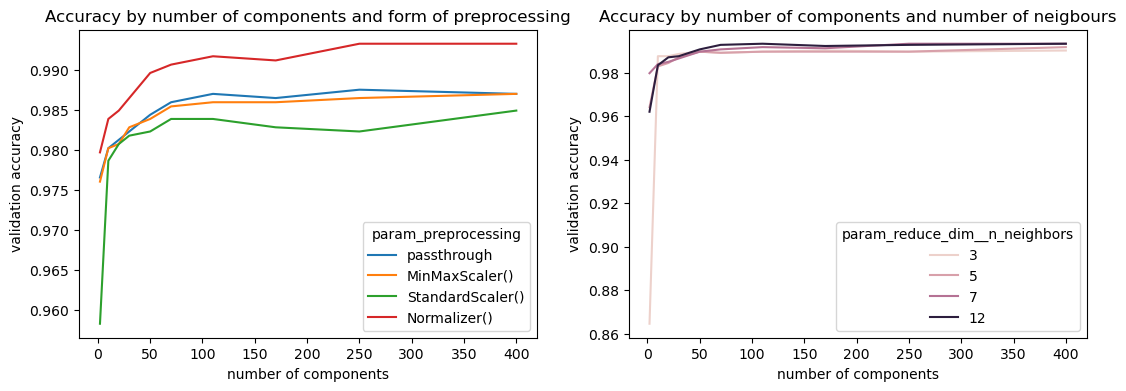

In [122]:
#inspect only better lda (with svd and without shrinkage)
res_modified = pd.DataFrame(lda_lle_grid.cv_results_)
res_modified["param_lda"] = res_modified["param_lda"].astype("string")
res_modified = res_modified[res_modified["param_lda"] == "LinearDiscriminantAnalysis()"]

plot_lle(res_modified, best_neigh=7, best_prep="Normalizer()")

U LLE opět normalizace řádků zvýšila přesnost. Zajímavé je, že zvyšuje přesnost pouze u LLE, ale u PCA ne. Také je vidět, že počet sousedů u LLE nemá na přesnost téměř žádný vliv a že maximální přesnost dostáváme pro 250 komponent.

## Výsledky

Nejlepší přesnost měl model SVM s normalizací jednotlivých řádků a redukcí dimenze pomocí LLE (99.4%). Otestuji jeho přesnost na testovacích datech.

In [60]:
from sklearn.metrics import accuracy_score
best_clf = svm_lle_grid.best_estimator_
pred = best_clf.predict(X_test)

print(f"Test accuracy: {accuracy_score(pred, y_test)}")

Test accuracy: 0.98125


Testovací přesnost vychází výrazně nižší než validační, ale pořád celkem dobrá.

Ze zvědavosti si ještě zobrazím několik obrázků, které byly predikovány špatně.

In [159]:
#make copy of the test dataset with reset index
result_df = X_test.copy()
result_df.reset_index(drop=True, inplace=True)

#add predictions and real labels to the original dataset
result_df["label"] = y_test.reset_index(drop=True)
result_df["prediction"] = pred

wrong_pred = result_df[result_df["label"] != result_df["prediction"]].reset_index(drop=True)
print(f"Number of wrong predictions: {wrong_pred.shape[0]}")

Number of wrong predictions: 9


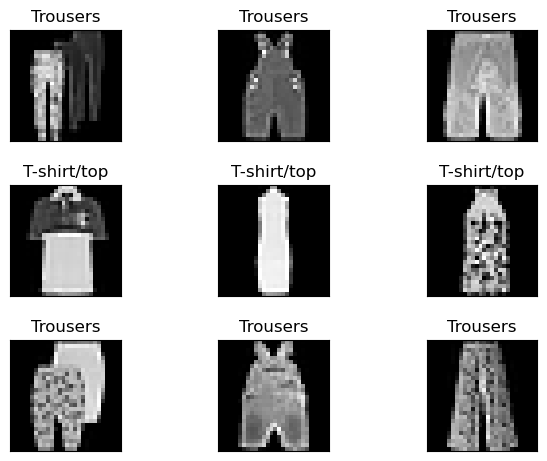

In [168]:
fig, ax = plt.subplots(3, 3)
fig.tight_layout()

for num, row in wrong_pred.iterrows():
    label = row["label"]
    row = row.drop(["label", "prediction"])
    img = np.array(row, dtype=int).reshape((28, 28))
    
    i = num // 3
    j = num % 3
    #plot in grayscale
    ax[i][j].imshow(img, cmap='gray', vmin=0, vmax=255)
    #remove ticks and numbers
    ax[i][j].tick_params(left = False, right = False,
                         labelleft = False ,labelbottom = False, bottom = False)
    if label == 0:
        ax[i][j].set_title("T-shirt/top")
    else:
        ax[i][j].set_title("Trousers")
        

S některými z výše zobrazených obrázků by měl při klasifikaci problém i člověk. Na některých je více kusů oblečení, overaly, trika bez rukávů nebo velmi široké kalhoty.

Jako poslední věc ještě napočítám a uložím predikce pro soubor `evaluate.csv`.

In [182]:
to_eval = pd.read_csv("evaluate.csv")
ID = to_eval["ID"]
to_eval.drop("ID", axis=1, inplace=True)
eval_pred = best_clf.predict(to_eval)
csv_df = pd.DataFrame({"ID" : ID, "label" : eval_pred})
csv_df.to_csv('results.csv', index=False)